# Linear Models

I'll be using [Alexandre Papius notebook](https://www.kaggle.com/apapiu/regularized-linear-models) and modify it according to my needs, so a big thanks to Alexandre! - July 2020

----------------------------------------------------------------


After working and understanding the data on the previous [notebook](https://drive.google.com/file/d/1Sw_vJRU2MeDBKt5HkXnzHtAJeH-7Ayj2/view?usp=sharing) we can start creating the models and further analyse the features for a final selection.

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib

import matplotlib.pyplot as plt
from scipy.stats import skew
from scipy.stats.stats import pearsonr


%config InlineBackend.figure_format = 'retina' #set 'png' here when working on notebook
%matplotlib inline

In [ ]:
# to mount your google drive
from google.colab import files 
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Remember where we stored the csv files we just created. You should change the path below according to your mounted drive.

In [ ]:
!ls -lrth "/content/drive/My Drive/Courses/Machine Learning - Data Science Academy/05 - Regressão part2/3-Cap05-Python/dados/"

total 2.4M
-rw------- 1 root root 441K Sep 30  2019 teste.csv
-rw------- 1 root root 450K Sep 30  2019 treino.csv
-rw------- 1 root root 667K Jun 25 17:33 train_worked.csv
-rw------- 1 root root 736K Jun 25 17:33 test_worked.csv
-rw------- 1 root root  78K Jun 25 17:33 validation_worked.csv


In [ ]:
# load the train file worked on the previous notebook
base_folder = "/content/drive/My Drive/Courses/Machine Learning - Data Science Academy/05 - Regressão part2/3-Cap05-Python/dados/"
df_train = pd.read_csv(base_folder + '/train_worked.csv')
df_test = pd.read_csv(base_folder + '/test_worked.csv')
df_validation = pd.read_csv(base_folder + '/validation_worked.csv')

The test dataset was not worked before, so before we can use it we should apply the same transformations that were applied on the train set.

In [ ]:
print(f"train shape:      {df_train.shape}")
print(f"validation shape: {df_validation.shape}")
print(f"test shape:       {df_test.shape}  ==> Unseen data used to make real predictions (has no target variable).")

train shape:      (1311, 221)
validation shape: (146, 221)
test shape:       (1459, 220)  ==> Unseen data used to make real predictions (has no target variable).


In [ ]:
df_train.head()

,Id,MSSubClass,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice,HasBsmt,MSZoning_C (all),MSZoning_FV,MSZoning_RH,MSZoning_RL,...,HeatingQC_Fa,HeatingQC_Gd,HeatingQC_Po,HeatingQC_TA,CentralAir_N,CentralAir_Y,Electrical_FuseA,Electrical_FuseF,Electrical_FuseP,Electrical_Mix,Electrical_SBrkr,KitchenQual_Ex,KitchenQual_Fa,KitchenQual_Gd,KitchenQual_TA,Functional_Maj1,Functional_Maj2,Functional_Min1,Functional_Min2,Functional_Mod,Functional_Sev,Functional_Typ,PavedDrive_N,PavedDrive_P,PavedDrive_Y,SaleType_COD,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,1411,60,12420,7,5,2001,2001,666,0,278,6.850126,944,896,0,7.517521,1,0,2,1,3,1,6,0,2,622,0,45,0,0,0,0,0,6,2009,12.345835,1,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
1,478,60,13693,9,5,2006,2006,0,0,2153,7.674617,2069,574,0,7.879670,0,0,2,1,3,1,9,1,3,694,414,84,0,0,0,0,0,3,2007,12.847927,1,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
2,367,20,9500,6,5,1963,1963,609,0,785,7.239933,1394,0,0,7.239933,1,0,1,1,3,1,6,2,2,514,0,76,0,0,185,0,0,7,2009,11.976659,1,0,0,0,1,...,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
3,1209,20,7763,5,7,1962,1980,504,108,319,6.836259,1283,0,0,7.156956,1,0,1,0,3,1,6,0,2,506,0,0,0,0,0,0,0,10,2008,11.849398,1,0,0,0,1,...,0,0,0,1,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
4,1139,20,9819,6,5,1977,1977,1567,0,0,7.356918,1567,0,0,7.356918,1,0,2,0,2,1,5,2,2,714,264,32,0,0,0,0,0,5,2009,12.185870,1,0,0,0,1,...,0,0,0,1,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0


In [ ]:
df_validation.head()

,Id,MSSubClass,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice,HasBsmt,MSZoning_C (all),MSZoning_FV,MSZoning_RH,MSZoning_RL,...,HeatingQC_Fa,HeatingQC_Gd,HeatingQC_Po,HeatingQC_TA,CentralAir_N,CentralAir_Y,Electrical_FuseA,Electrical_FuseF,Electrical_FuseP,Electrical_Mix,Electrical_SBrkr,KitchenQual_Ex,KitchenQual_Fa,KitchenQual_Gd,KitchenQual_TA,Functional_Maj1,Functional_Maj2,Functional_Min1,Functional_Min2,Functional_Mod,Functional_Sev,Functional_Typ,PavedDrive_N,PavedDrive_P,PavedDrive_Y,SaleType_COD,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,1025,20,15498,8,6,1976,1976,1165,400,0,7.355641,2898,0,0,7.971776,1,0,2,0,2,1,10,1,2,665,0,72,174,0,0,0,0,5,2008,12.567237,1,0,0,0,1,...,0,0,0,1,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0
1,874,40,12144,5,7,1949,1950,375,0,457,6.723832,1036,0,232,7.145196,0,0,1,0,3,1,6,1,1,288,0,28,0,0,0,0,0,9,2009,11.798104,1,0,0,0,1,...,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
2,1180,20,8335,5,5,1954,1954,0,0,0,0.000000,1124,0,0,7.024649,0,0,1,0,3,1,5,1,0,0,0,36,190,0,0,0,0,4,2006,11.440355,0,0,0,0,1,...,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
3,1182,120,5587,8,5,2008,2008,1480,0,120,7.377759,1652,0,0,7.409742,1,1,2,0,2,1,5,1,2,482,162,53,0,153,0,0,0,11,2008,12.880292,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1
4,269,30,6900,5,6,1940,1955,403,125,212,6.606650,778,0,0,6.656727,0,0,1,0,2,1,4,1,1,924,0,25,0,0,0,0,0,2,2008,11.699405,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0


In [ ]:
df_test.head()

,Id,MSSubClass,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,HasBsmt,MSZoning_C (all),MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,...,HeatingQC_Fa,HeatingQC_Gd,HeatingQC_Po,HeatingQC_TA,CentralAir_N,CentralAir_Y,Electrical_FuseA,Electrical_FuseF,Electrical_FuseP,Electrical_Mix,Electrical_SBrkr,KitchenQual_Ex,KitchenQual_Fa,KitchenQual_Gd,KitchenQual_TA,Functional_Maj1,Functional_Maj2,Functional_Min1,Functional_Min2,Functional_Mod,Functional_Sev,Functional_Typ,PavedDrive_N,PavedDrive_P,PavedDrive_Y,SaleType_COD,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,1461,20,11622,5,6,1961,1961,468.0,144.0,270.0,6.782192,896,0,0,6.797940,0.0,0.0,1,0,2,1,5,0,1.0,730.0,140,0,0,0,120,0,0,6,2010,1,0,0,1,0,0,...,0,0,0,1,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
1,1462,20,14267,6,6,1958,1958,923.0,0.0,406.0,7.192182,1329,0,0,7.192182,0.0,0.0,1,1,3,1,6,0,1.0,312.0,393,36,0,0,0,0,12500,6,2010,1,0,0,0,1,0,...,0,0,0,1,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
2,1463,60,13830,5,5,1997,1998,791.0,0.0,137.0,6.833032,928,701,0,7.395722,0.0,0.0,2,1,3,1,6,1,2.0,482.0,212,34,0,0,0,0,0,3,2010,1,0,0,0,1,0,...,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
3,1464,60,9978,6,6,1998,1998,602.0,0.0,324.0,6.830874,926,678,0,7.380256,0.0,0.0,2,1,3,1,7,1,2.0,470.0,360,36,0,0,0,0,0,6,2010,1,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
4,1465,120,5005,8,5,1992,1992,263.0,0.0,1017.0,7.154615,1280,0,0,7.154615,0.0,0.0,2,0,2,1,5,0,2.0,506.0,0,82,0,0,144,0,0,1,2010,1,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0


In [ ]:
df_train[["SalePrice"]].head()

,SalePrice
0,12.345835
1,12.847927
2,11.976659
3,11.849398
4,12.185870


In [ ]:
df_validation[["SalePrice"]].head()

,SalePrice
0,12.567237
1,11.798104
2,11.440355
3,12.880292
4,11.699405


The `SalePrice` is already log transformed:

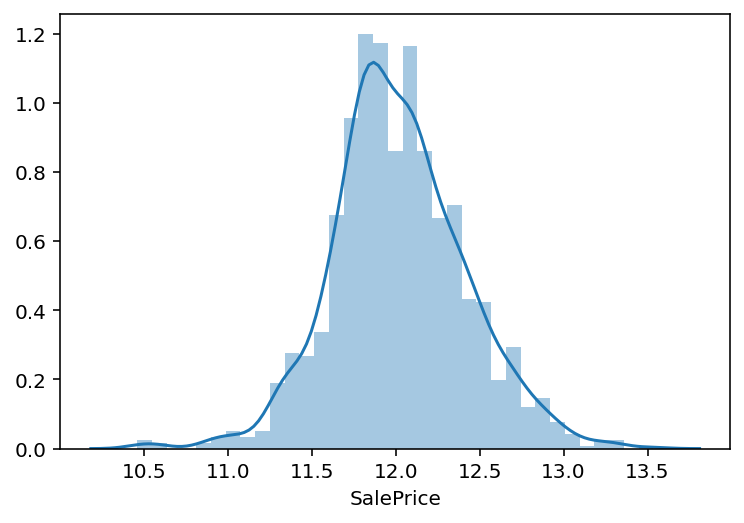

In [ ]:
#histogram
sns.distplot(df_train['SalePrice']);

In [ ]:
#skewness and kurtosis
print("Skewness: %f" % df_train['SalePrice'].skew())
print("Kurtosis: %f" % df_train['SalePrice'].kurt())

Skewness: 0.095678
Kurtosis: 0.869163


In [ ]:
#creating matrices for sklearn:
X_train = df_train.drop(columns=['SalePrice'])
y_train = df_train.SalePrice

X_val = df_validation.drop(columns=['SalePrice'])
y_val = df_validation.SalePrice

In [ ]:
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)

(1311, 220)
(1311,)
(146, 220)
(146,)


###Models

Now we are going to use regularized linear regression models from the scikit learn module. I'm going to try both l_1(Lasso) and l_2(Ridge) regularization. I'll also define a function that returns the cross-validation rmse error so we can evaluate our models and pick the best tuning par

## Cross-Validation

<img src="https://scikit-learn.org/stable/_images/grid_search_workflow.png" width="500"/>


Another part of the dataset can be held out as a so-called “validation set”: training proceeds on the training set, after which evaluation is done on the validation set, and when the experiment seems to be successful, final evaluation can be done on the test set.

However, by partitioning the available data into three sets, we drastically reduce the number of samples which can be used for learning the model, and the results can depend on a particular random choice for the pair of (train, validation) sets.

A solution to this problem is a procedure called cross-validation (CV for short). A test set should still be held out for final evaluation, but the validation set is no longer needed when doing CV. In the basic approach, called k-fold CV, the training set is split into k smaller sets (other approaches are described below, but generally follow the same principles). The following procedure is followed for each of the k “folds”:

- A model is trained using `K-1`of the folds as training data;
- the resulting model is validated on the remaining part of the data (i.e., it is used as a test set to compute a performance measure such as accuracy).

The performance measure reported by k-fold cross-validation is then the average of the values computed in the loop. This approach can be computationally expensive, but does not waste too much data (as is the case when fixing an arbitrary validation set), which is a major advantage in problems such as inverse inference where the number of samples is very small.

<img src="https://scikit-learn.org/stable/_images/grid_search_cross_validation.png" width="600"/>

To learn more about **Cross Validation** go to this [link](https://scikit-learn.org/stable/modules/cross_validation.html)


We'll be using **Validation data as Test data** on the pictures above for this case we're working on. The **Cross validation is performed using the K-fold sets on training data** as usual.

In [ ]:
from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, LassoCV, LassoLarsCV
from sklearn.model_selection import cross_val_score

def rmse_cv(model):
    rmse= np.sqrt(-cross_val_score(model, X_train, y_train, scoring="neg_mean_squared_error", cv = 5))
    return(rmse)

In [ ]:
model_ridge = Ridge()

The main tuning parameter for the Ridge model is alpha - a regularization parameter that measures how flexible our model is. The higher the regularization the less prone our model will be to overfit. However it will also lose flexibility and might not capture all of the signal in the data.

In [ ]:
alphas = [0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 50, 75]
cv_ridge = [rmse_cv(Ridge(alpha = alpha)).mean() 
            for alpha in alphas]

Text(0, 0.5, 'rmse')

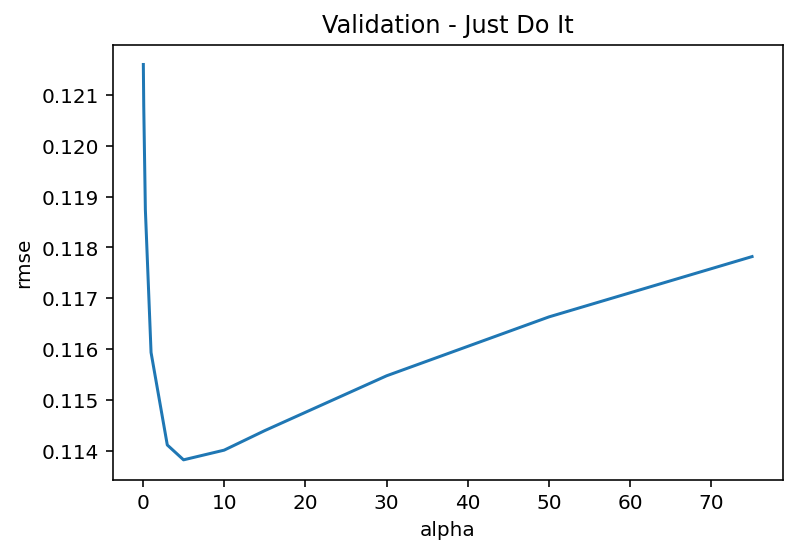

In [ ]:
cv_ridge = pd.Series(cv_ridge, index = alphas)
cv_ridge.plot(title = "Validation - Just Do It")
plt.xlabel("alpha")
plt.ylabel("rmse")

The best value for alpha is 5.

(0.11343358974094155, 0.115)

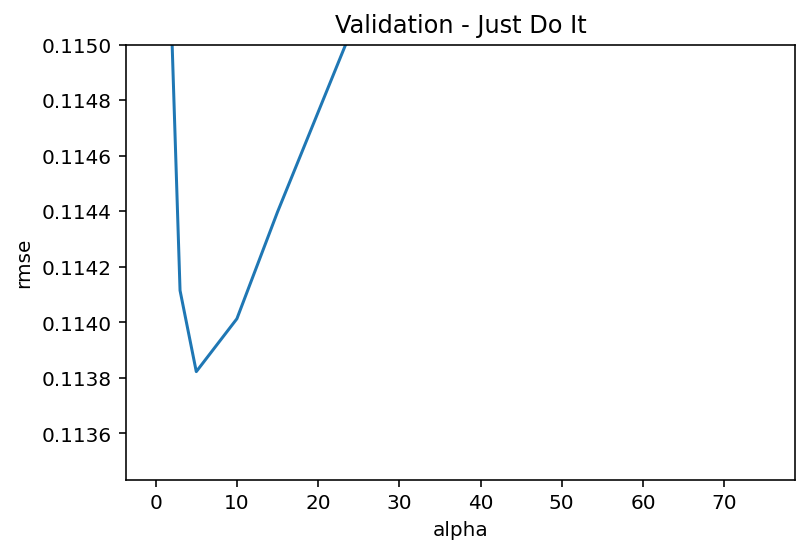

In [ ]:
cv_ridge = pd.Series(cv_ridge, index = alphas)
cv_ridge.plot(title = "Validation - Just Do It")
plt.xlabel("alpha")
plt.ylabel("rmse")
plt.ylim(top=0.115)

Note the U-ish shaped curve above. When alpha is too large the regularization is too strong and the model cannot capture all the complexities in the data. If however we let the model be too flexible (alpha small) the model begins to overfit. A value of alpha = 5 is about right based on the plot above.

In [ ]:
cv_ridge

0.05     0.121600
0.10     0.120788
0.30     0.118743
1.00     0.115935
3.00     0.114115
5.00     0.113822
10.00    0.114013
15.00    0.114397
30.00    0.115476
50.00    0.116635
75.00    0.117821
dtype: float64

In [ ]:
cv_ridge.min()

0.11382247734657074

So for the Ridge regression we get a rmsle of about 0.113



In [ ]:
ridge_model = Ridge(alpha=5, fit_intercept=True, normalize=False)

In [ ]:
ridge_model.fit(X_train, y_train)

Ridge(alpha=5, copy_X=True, fit_intercept=True, max_iter=None, normalize=False,
      random_state=None, solver='auto', tol=0.001)

In [ ]:
#dir(ridge_model)

In [ ]:
coef = pd.Series(ridge_model.coef_, index = X_train.columns)

In [ ]:
coef.sort_values().head()

MSZoning_C (all)       -0.181440
Neighborhood_MeadowV   -0.080844
Functional_Maj2        -0.072422
Heating_Grav           -0.071685
LandSlope_Sev          -0.052916
dtype: float64

In [ ]:
coef.sort_values().tail()

Exterior1st_BrkFace     0.069643
Neighborhood_StoneBr    0.087886
Functional_Typ          0.092688
Neighborhood_Crawfor    0.101679
GrLivArea               0.115958
dtype: float64

In [ ]:
imp_coef = pd.concat([coef.sort_values().head(10),
                     coef.sort_values().tail(10)])

Text(0.5, 1.0, 'Coefficients in the Ridge Model')

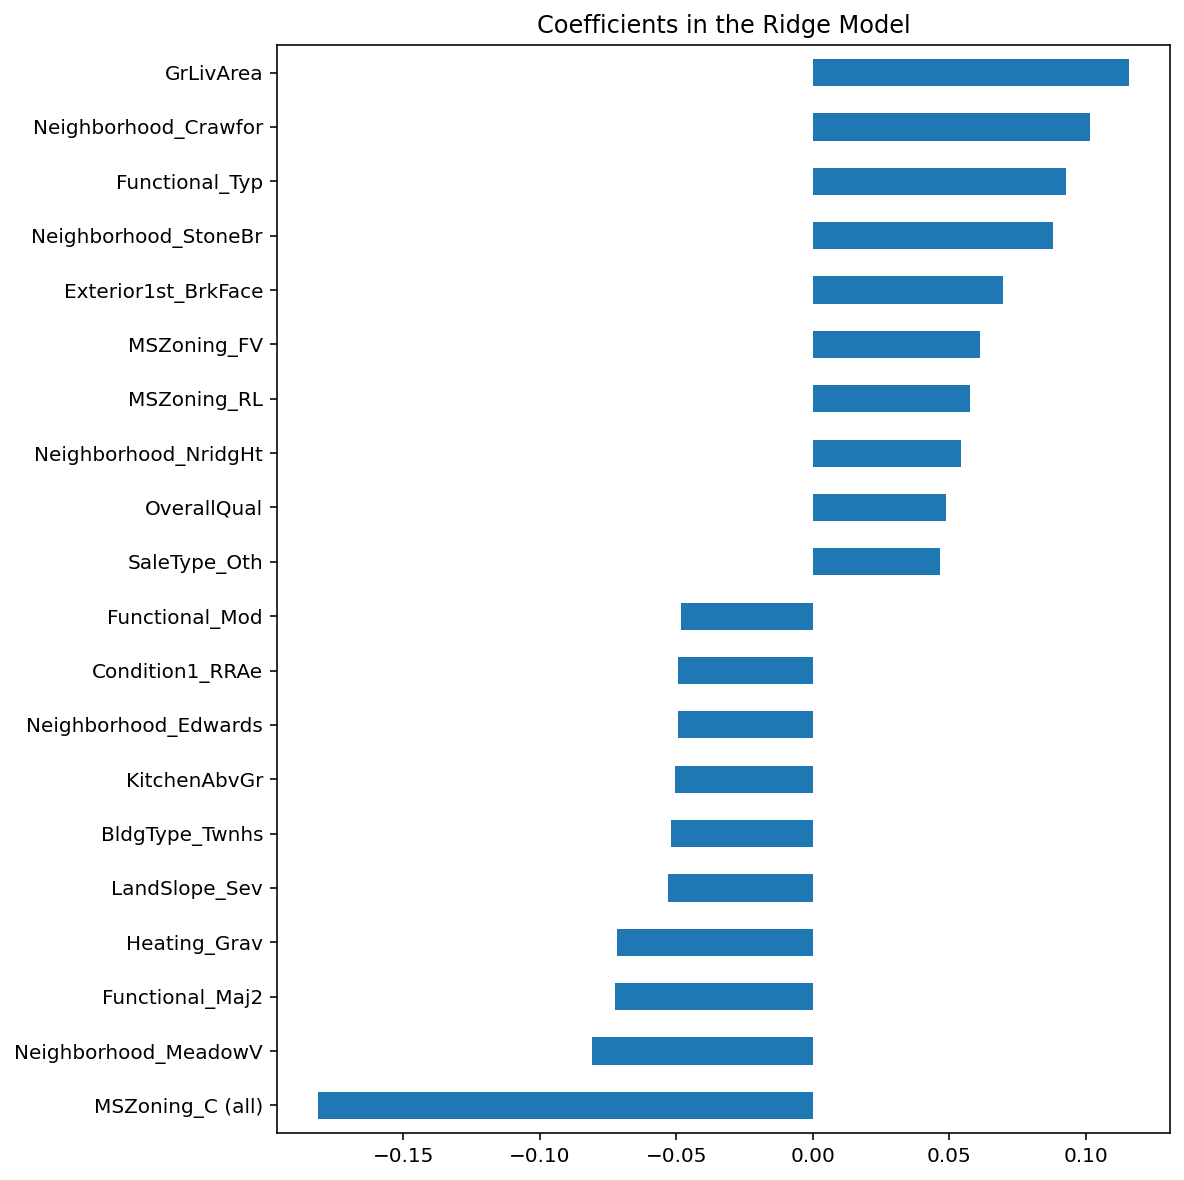

In [ ]:
matplotlib.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "barh")
plt.title("Coefficients in the Ridge Model")

Let' try out the Lasso model. We will do a slightly different approach here and use the built in Lasso CV to figure out the best alpha for us. For some reason the alphas in Lasso CV are really the inverse or the alphas in Ridge.

In [ ]:
model_lasso = LassoCV(alphas = [1, 0.1, 0.001, 0.0005]).fit(X_train, y_train)

In [ ]:
rmse_cv(model_lasso).mean()

0.11369951932811954

Nice! The lasso performs even better so we'll just use this one to predict on the test set. Another neat thing about the Lasso is that it does feature selection for you - setting coefficients of features it deems unimportant to zero. Let's take a look at the coefficients:

In [ ]:
coef = pd.Series(model_lasso.coef_, index = X_train.columns)

In [ ]:
print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")

Lasso picked 95 variables and eliminated the other 125 variables


Good job Lasso. One thing to note here however is that the features selected are not necessarily the "correct" ones - especially since there are a lot of collinear features in this dataset. One idea to try here is run Lasso a few times on boostrapped samples and see how stable the feature selection is.

We can also take a look directly at what the most important coefficients are:


In [ ]:
imp_coef = pd.concat([coef.sort_values().head(10),
                     coef.sort_values().tail(10)])

Text(0.5, 1.0, 'Coefficients in the Lasso Model')

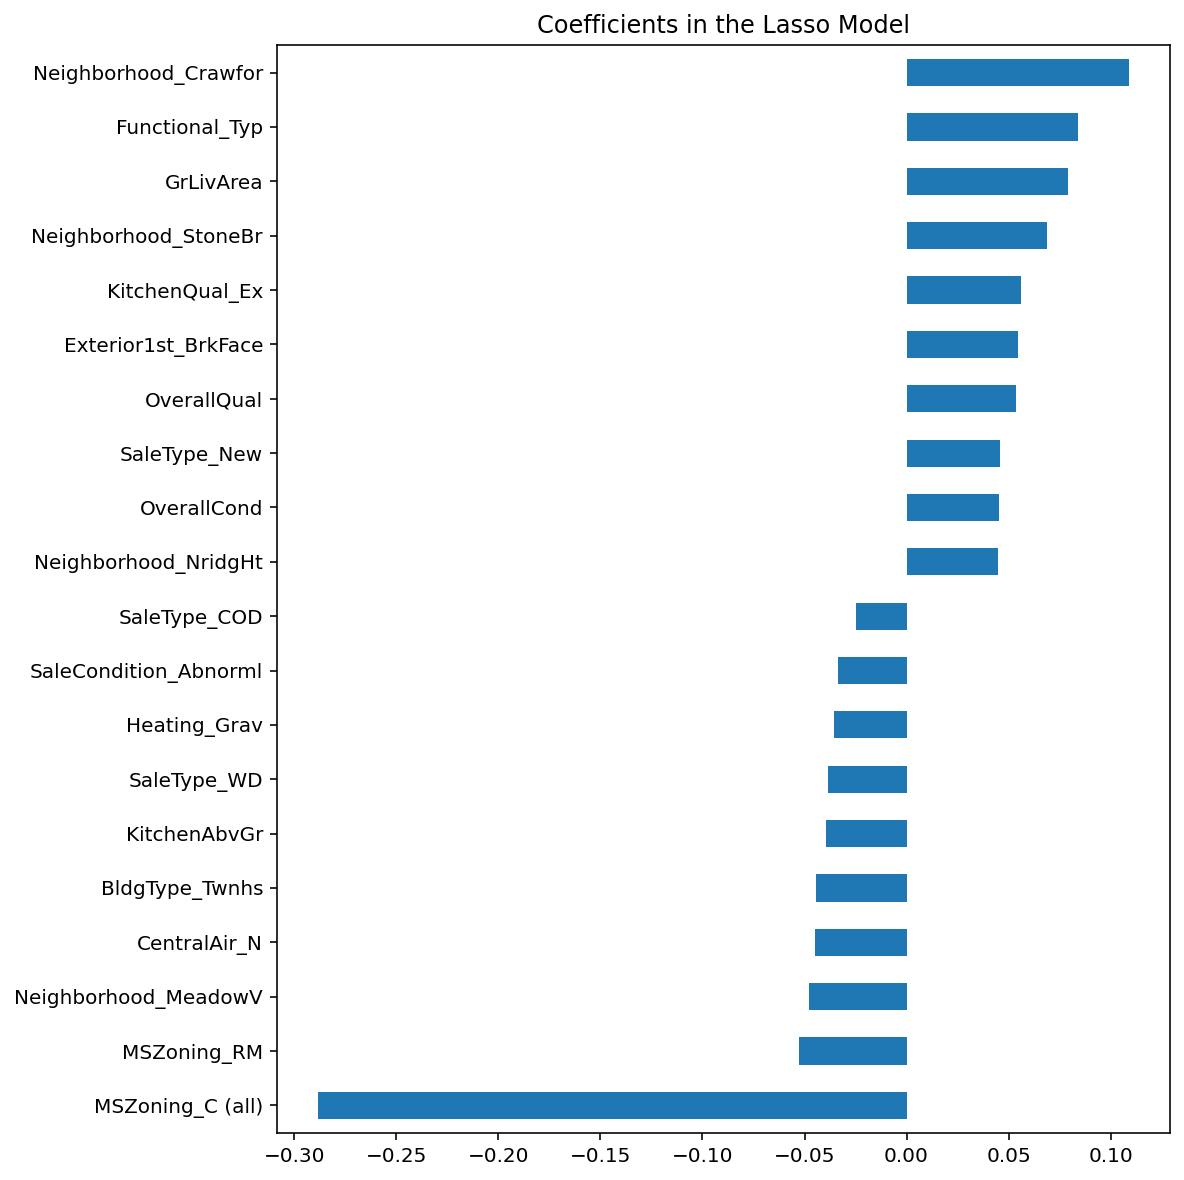

In [ ]:
matplotlib.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "barh")
plt.title("Coefficients in the Lasso Model")

The most important positive feature is NeigborhoodCrawfor. This definitely sense. Then a few other location and quality features contributed positively. Some of the negative features make less sense and would be worth looking into more - it seems like they might come from unbalanced categorical variables.

Also note that unlike the feature importance you'd get from a random forest these are actual coefficients in your model - so you can say precisely why the predicted price is what it is. The only issue here is that we log_transformed both the target and the numeric features so the actual magnitudes are a bit hard to interpret.


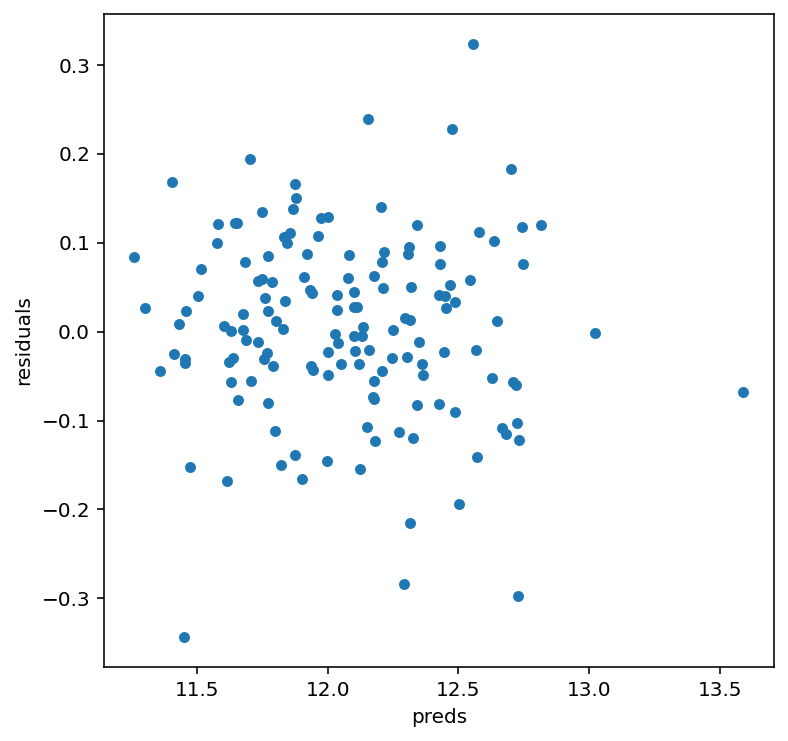

In [ ]:
#let's look at the residuals as well:
matplotlib.rcParams['figure.figsize'] = (6.0, 6.0)

# make prediction on the validation dataset
preds = pd.DataFrame({"preds":model_lasso.predict(X_val), "true":y_val})
preds["residuals"] = preds["true"] - preds["preds"]
preds.plot(x = "preds", y = "residuals",kind = "scatter")

Now lets predict the SalePrice on the test set.

In [ ]:
# df_test is our X_test since it has no target variable (y_test)
model_lasso.predict(df_test)

ValueError: ignored

We got some error here, since this test dataset is kind of 'raw' compared to the training.

In [ ]:
np.all(np.isfinite(df_test))

False

In [ ]:
# There must be NaN values 
np.any(np.isnan(df_test))

True

In [ ]:
df_test.isnull().sum().sort_values(ascending=False).head(10)

BsmtFullBath            2
BsmtHalfBath            2
BsmtFinSF1              1
GarageCars              1
GarageArea              1
TotalBsmtSF             1
BsmtUnfSF               1
BsmtFinSF2              1
Neighborhood_NridgHt    0
Neighborhood_Mitchel    0
dtype: int64

Lets get rid of the rows with Null values and go forward.

In [ ]:
df_test = df_test.dropna()

In [ ]:
print(df_test.shape)

(1456, 220)


In [ ]:
# df_test is our X_test since it has no target variable (y_test)
test_pred = model_lasso.predict(df_test)

In [ ]:
test_pred

array([11.68755083, 11.93183197, 12.08217647, ..., 12.01945619,
       11.65187187, 12.34903492])

Now remember that our models were trained with `y` being the `log(SalePrice)`? That means that it will predict the `log` of the `SalePrice` and that is meaningless to the bussiness area. They want to know the real value ($$$) that they'll sell a house, and not a `log` of it.

Therefore we need to undo this transformation to the predictions have some sense, right?

So we'll make it by applying `np.exp()` function to it. This function 'undo' the `np.log()` transformation, resulting in a pure currency value that is expected.

In [ ]:
real_predictions = np.exp(test_pred)

In [ ]:
real_predictions

array([119080.00192182, 152029.82082427, 176694.31267441, ...,
       165952.38501134, 114906.25195794, 230737.25531386])

Well, that's it.


# References

- [Paulo Cressoni github](https://github.com/paulocressoni)
- [Alexandre Papius notebook](https://www.kaggle.com/apapiu/regularized-linear-models)